## logistic regression model

#### import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### load cleaned feature data table

In [2]:
df = pd.read_feather('../data/processed/df_to_model')

In [3]:
df.columns

Index(['time_on_vent', 'anchor_age', 'spontrr', 'heartrate', 'std_spontrr',
       'weight', 'bloodpressure', 'std_pulseox', 'std_heartrate', 'height',
       'tidalvolume', 'temp', 'std_bloodpressure', 'pulseox', 're_intub_class',
       'gender', 'admission_type', 'newpulse'],
      dtype='object')

In [4]:
df[df['re_intub_class']==0]

,time_on_vent,anchor_age,spontrr,heartrate,std_spontrr,weight,bloodpressure,std_pulseox,std_heartrate,height,tidalvolume,temp,std_bloodpressure,pulseox,re_intub_class,gender,admission_type,newpulse
0,3.257455,5184.0,19.0,79.0,1.551546,123.2,62.0,0.000000,1.088973,59.921260,387.0,36.444444,3.060937,100.0,0,F,EW EMER.,100.0
1,2.833213,529.0,33.0,122.0,1.521199,264.0,101.0,1.025631,2.692730,70.933071,527.0,39.166667,1.994816,96.0,0,M,EW EMER.,96.0
2,6.363430,6561.0,24.0,63.0,1.025631,198.0,79.0,0.983321,1.672291,61.905512,437.0,36.833333,2.004007,96.0,0,F,EW EMER.,96.0
3,5.135798,4225.0,15.0,80.0,1.198942,205.9,105.0,0.455746,1.533244,61.905512,614.0,37.333333,1.705757,100.0,0,F,URGENT,100.0
4,4.429228,3721.0,18.0,73.0,2.246625,199.5,87.0,0.000000,2.162651,66.070866,556.0,36.444444,2.124247,100.0,0,F,EW EMER.,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6783,3.100843,5476.0,15.0,60.0,1.778227,121.0,98.0,0.000000,1.125470,66.070866,390.0,36.888889,1.451868,100.0,0,F,URGENT,100.0
6784,4.964824,3481.0,21.0,88.0,1.110344,233.0,85.0,0.922899,2.149769,66.070866,334.0,36.555556,2.446675,96.0,0,M,EW EMER.,96.0
6785,3.054787,3249.0,19.0,83.0,1.641582,255.2,78.0,0.709412,1.112266,68.501969,401.0,37.333333,1.482939,96.0,0,F,ELECTIVE,96.0
6786,2.145931,3721.0,19.0,50.0,2.432938,197.1,94.0,0.684708,1.384903,70.039370,482.0,36.222222,1.895647,97.0,0,M,EW EMER.,97.0


## Handle categoricals

In [5]:
X = df[df.columns.drop('re_intub_class')]
y = df['re_intub_class']

In [6]:
# Import libraries 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [7]:
numeric_features  = df[df.columns.drop(['gender','admission_type','re_intub_class'])].columns
numeric_transformer = Pipeline(steps=[
   # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = df[['gender','admission_type']].columns
categorical_transformer = Pipeline(steps=[
   # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
scaled_data = preprocessor.fit_transform(X)

In [9]:
np.size(scaled_data,1)

22

In [10]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.2,random_state = 101)

In [11]:
oversample = SMOTE(random_state = 101)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [12]:
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']},]

rfc_param_grid=[
    {'n_estimators' : list(range(10,101,10)),
    'max_features' : list(range(6,32,5))}]

svc_param_grid ={ 'kernel':('linear', 'rbf'), 
                 'C': [0.1,1, 10, 100, 1000], 
                 'gamma': [1,0.1,0.01,0.001,0.0001]}

In [13]:
clf = GridSearchCV(LogisticRegression(),param_grid,refit=True)
clf.fit(X_smote,y_smote)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}])

In [25]:
clf.best_params_

{'C': 0.012742749857031334, 'penalty': 'l1', 'solver': 'liblinear'}

In [14]:
clf.best_estimator_.coef_

array([[ 0.34501466,  0.05106965,  0.02425595,  0.15068205,  0.02434326,
        -0.1145538 ,  0.        ,  0.00703958,  0.02135146,  0.00363019,
        -0.01357972,  0.        ,  0.01391769,  0.        ,  0.        ,
         0.        , -0.00310482,  0.        ,  0.        ,  0.13839779,
         0.        ,  0.        ]])

In [15]:
predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.57      0.70      1355
           1       0.13      0.61      0.22       148

    accuracy                           0.57      1503
   macro avg       0.53      0.59      0.46      1503
weighted avg       0.85      0.57      0.66      1503

[[766 589]
 [ 58  90]]


In [16]:
clf.predict_log_proba(X_test)

array([[-0.60672569, -0.78774995],
       [-0.61196514, -0.78150672],
       [-0.80238267, -0.5946777 ],
       ...,
       [-0.82143609, -0.57946072],
       [-1.1414104 , -0.38473389],
       [-0.4984053 , -0.93521534]])

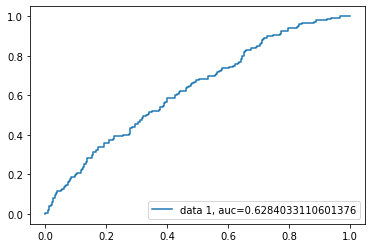

In [17]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### 5. Evaulate model

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.57      0.70      1355
           1       0.13      0.61      0.22       148

    accuracy                           0.57      1503
   macro avg       0.53      0.59      0.46      1503
weighted avg       0.85      0.57      0.66      1503



In [20]:
print(confusion_matrix(y_test,predictions))

[[766 589]
 [ 58  90]]


In [21]:
import joblib

In [22]:
#joblib.dump(logmodel, "reintubate_model_log.sav")

In [23]:
#joblib.dump(scaler, "reintubate_scaler.sav")

## Train model

### perform train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 3. SMOTE IT!

from collections import Counter
counter = Counter(y_train)
print(counter)

# transform the dataset
oversample = SMOTE(random_state = 101)

X_smote, y_smote = oversample.fit_resample(X_train, y_train)

counter = Counter(y_smote)
print(counter)

#### 4. Do logistic regression model

from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(max_iter=1000, C=0.0001)
logmodel.fit(X_smote,y_smote)

import pickle

In [24]:
# Save the model as a pickle in a file 
#pickle.dump(logmodel, open("reintubate_model_log", 'wb')) 

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features  = df[df.columns.drop(['gender','admission_type','re_intub_class'])].columns
#numeric_transformer = ('scaler', StandardScaler())
numeric_transformer = make_column_transformer(
    (StandardScaler(), numeric_features),
    remainder='passthrough')


categorical_features = df[['gender','admission_type']].columns
#categorical_transformer =  ('onehot', OneHotEncoder(drop='first'))
categorical_transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), categorical_features),
    remainder='passthrough')

#preprocessor = make_column_transformer(
 #   transformers=[
  #      ('num', numeric_transformer, numeric_features),
   #     ('cat', categorical_transformer, categorical_features)],
#remainder ='passthrough')

clf = Pipeline(steps=[('num', numeric_transformer),
                      ('cat', categorical_transformer),
                      ('classifier', LogisticRegression())])

#### 2. Perform feature scaling

Because the range of values in the features are not necessarily in the same order of magnitude, we will scale the feature data prior to training the model.

* actually... they might not be far off! 

mask=['spontRR', 'stdABP', 'meanABP', 'stdSpontRR', 'pulseox', 'stdPulseox',
       'temp', 'heartRate', 'stdHeartRate', 'weight', 'height', 'anchor_age',
       'time_on_vent']

X_traina = X_train.copy()
X_testa = X_test.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.loc[:,mask])
X_traina.loc[:,mask] = scaler.transform(X_train.loc[:,mask])

#X_train = scaler.transform(X_train)
X_testa.loc[:,mask] = scaler.transform(X_test.loc[:,mask])